<a href="https://colab.research.google.com/github/maciekpiotrowski/playground/blob/master/wine_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Najprostszy model ML ever

Ten notebook jest dodatkiem do postu na blogu UczymyMaszyny.pl


Zaimportujmy potrzebne biblioteki. To nasz pierwszy model, więc zacznijmy jak najprościej. Idźmy zgodnie z duchem twórców biblioteki Fast.AI - Get straight into the code, start building models :)

In [0]:
from fastai.tabular import * 

Będziemy posługiwać się zbiorem danych o winach, dostępnym na stronie https://archive.ics.uci.edu/ml/machine-learning-databases/wine

Pobierzmy zatem ten zbiór na lokalny dysk

In [0]:
import requests
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
data_file = open("./wine.data", "wb").write(requests.get(url).content)


W dokumentacji możemy wyczytać, że zbiór ten zawiera następujące informacje o każdym winie:

In [0]:
attributes = [
    "category",
    "Alcohol",
    "Malic_acid",
    "Ash",
    "Alcalinity_of_ash",
    "Magnesium",
    "Total_phenols",
    "Flavanoids",
    "Nonflavanoid_phenols",
    "Proanthocyanins",
    "Color_intensity",
    "Hue",
    "OD280_OD315_of_diluted_wines",
    "Proline"
]

Nie wiemy do końca co one oznaczają. Zerknijmy w dane!

In [0]:
df = pd.read_csv("wine.data", header=None, names=attributes)

Ile mamy wierszy danych?

In [0]:
len(df)

178

Obejrzyjmy pierwsze 5 próbek.

In [0]:
df.head()

,category,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280_OD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


I podsumujmy dane z każdej kolumny.

In [0]:
df.describe()

,category,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280_OD315_of_diluted_wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


Sprawdźmy czy dane są zbalansowen - zobaczmy wykres liczby próbek w każdej z 3 klas

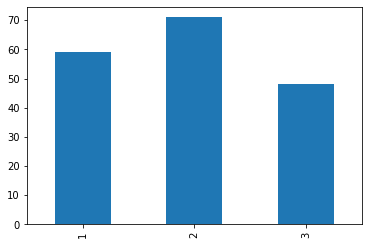

In [0]:
df['category'] \
    .value_counts() \
    .sort_index() \
    .plot.bar()

Powiedzmy, że mamy w miarę zbalansowane.

Czy mamy jakieś braki w danych?

In [0]:
df[df.isnull().any(1)]


,category,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280_OD315_of_diluted_wines,Proline


## Podział danych

Podzielimy sobie teraz dane na zbiory treningowy i testowy

Do zbioru testowego odłożymy 25% danych

In [0]:
# sprawdźmy, ile to jest 25%
valid_count = int(len(df) * 0.25)

# pomieszajmy wiersze w tabeli
df = df.sample(frac=1).reset_index(drop=True)

# i weźmy 25% "dolnych" rekordów
valid_idx = range(len(df) - valid_count, len(df))

valid_idx

range(134, 178)

## Czas na preprocessing

W Fast.AI mamy zbiór gotowych klas, które po prostu przekażemy jako listę przy wczytaniu danych. W naszym przypadku chcemy dane jedynie znormalizować.

In [0]:
preprocessing_steps = [Normalize]

Co jeszcze musimy zrobić przed wczytaniem danych do specjalnej klasy, to wskazanie, którą z wartości chcemy przewidywać - czyli nasz target / label / klasę (możesz się spotkać z różnymi terminami)

In [0]:
target_var = 'category'

Czas na wczytanie danych do formatu, który w Fast.AI będziemy mogli później wykorzystać przy treningu. Do "wczytywacza" przekażemy nasz DataFrame, kolumnę z labelką, ID rekordów ze zbioru testowego i listę funkcji preprocessingu. 

In [0]:
data = TabularDataBunch.from_df(".", df, target_var, valid_idx=valid_idx, procs=preprocessing_steps)

Mamy dane, czas na uczenie!

## Uczenie

Tworzymy obiekt TabularLearner na naszych danych. Będzie to sieć neuronowa o 2 warstwach, 200 neuronach w pierwszej i 100 w drugiej warstwie. 

Jak wspominaliśmy, metryką będzie skuteczność, czyli accuracy

In [0]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)


I trenujemy, czyli "fitujemy" nasz model do danych. Będziemy trenować korzystając z 1 cycle policy - domyślny sposób w Fast.AI

In [0]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.242008,0.771216,0.977273,00:00


## Walidacja

In [0]:
learn.validate()

[0.77121603, tensor(0.9773)]

Alternatywna składnia, z przekazaniem zbioru do walidacji.

In [0]:
learn.validate(learn.data.valid_dl)

[0.77121603, tensor(0.9773)]

## Predykcje

In [0]:
preds, _ = learn.get_preds(data.valid_ds)
pred_prob, pred_class = preds.max(1)
pred_prob, pred_class

(tensor([0.4247, 0.5110, 0.4768, 0.4589, 0.4575, 0.4766, 0.5001, 0.4715, 0.4808,
         0.4757, 0.4233, 0.4516, 0.3616, 0.5895, 0.3942, 0.4276, 0.3568, 0.5532,
         0.4562, 0.5358, 0.5876, 0.4888, 0.5528, 0.5802, 0.5677, 0.4777, 0.5972,
         0.4991, 0.3964, 0.4993, 0.4334, 0.6598, 0.4280, 0.4902, 0.4292, 0.4212,
         0.4147, 0.4245, 0.4210, 0.4164, 0.6913, 0.3990, 0.6158, 0.4334, 0.4892,
         0.5215, 0.3546, 0.4317, 0.3979, 0.5619, 0.4006, 0.5653, 0.4773, 0.4660,
         0.4276, 0.4740, 0.4332, 0.4209, 0.3880, 0.5135, 0.4845, 0.4511, 0.4564,
         0.7182, 0.4896, 0.4003, 0.4817, 0.5776, 0.6423, 0.4692, 0.4464, 0.5592,
         0.5027, 0.4780, 0.4551, 0.5400, 0.5454, 0.3869, 0.5131, 0.4549, 0.4344,
         0.4625, 0.4728, 0.5577, 0.6927, 0.5021, 0.3953, 0.4796, 0.5255, 0.4899,
         0.5174, 0.4363, 0.5690, 0.5300, 0.4647, 0.4496, 0.4148, 0.6154, 0.4193,
         0.4839, 0.4116, 0.4739, 0.4696, 0.5571, 0.5090, 0.3992, 0.4382, 0.6517,
         0.4517, 0.6086, 0.4